In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-electricity-usage-and-production/electricityConsumptionAndProductioction.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from prophet import Prophet

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

df = pd.read_csv("/kaggle/input/hourly-electricity-usage-and-production/electricityConsumptionAndProductioction.csv")

# set the DateTime as the index
df = df.set_index("DateTime")
df.index = pd.to_datetime(df.index)

In [4]:
print(f"Our Shape is {df.shape}")
print()
df.head()

Our Shape is (36772, 9)



,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [5]:
df.drop(["Production", "Nuclear", "Wind", "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"], axis=1, inplace=True)

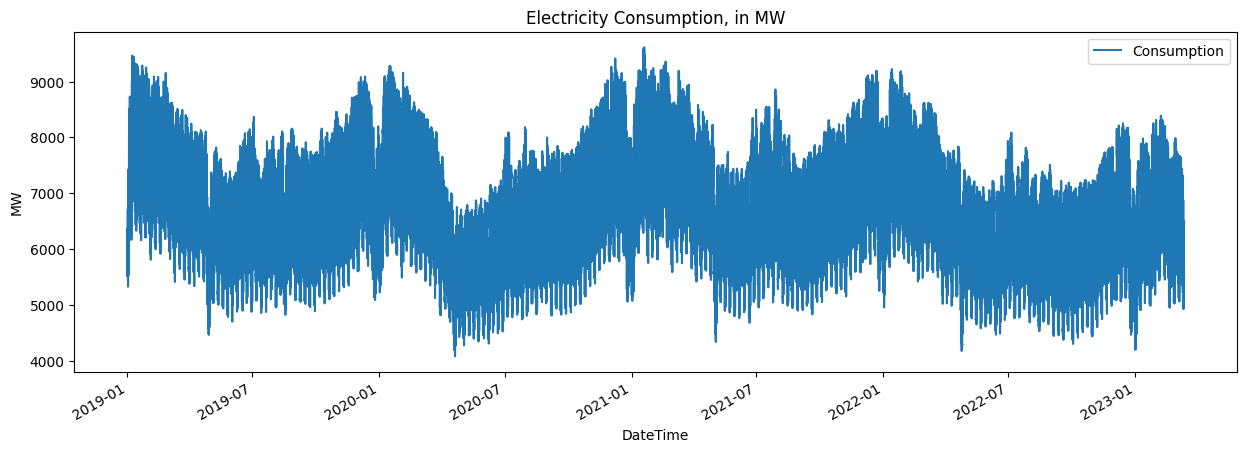

In [6]:
df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

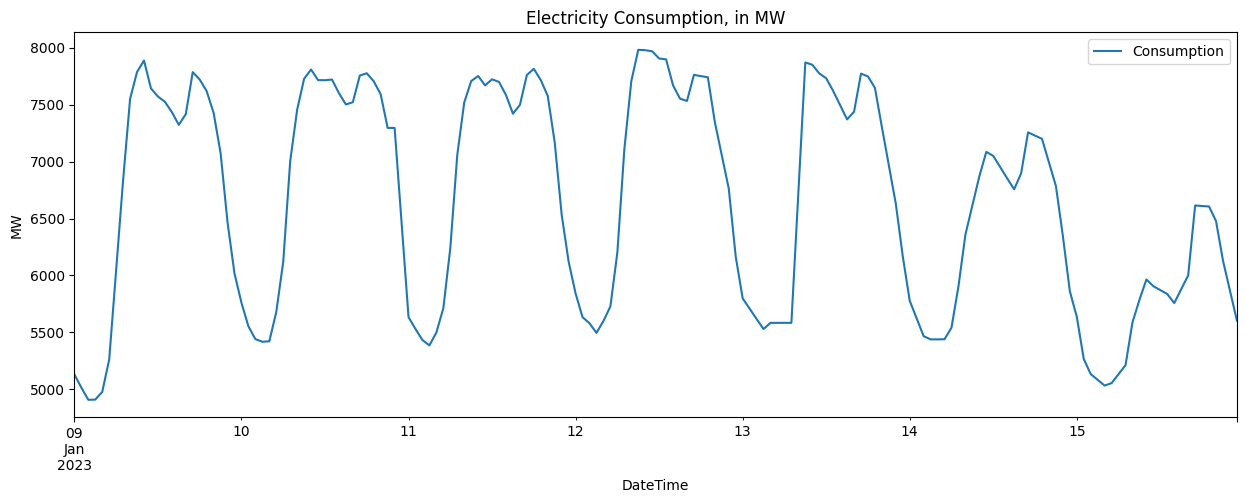

In [7]:
df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

In [8]:
# method for adding time features by the time index
def createTimeFeatures(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear


# apply the method to the existing dataframe
createTimeFeatures(df)

df.head()

,Consumption,hour,day_of_week,quarter,month,year,day_of_year
DateTime,,,,,,,
2019-01-01 00:00:00,6352,0,1,1,1,2019,1
2019-01-01 01:00:00,6116,1,1,1,1,2019,1
2019-01-01 02:00:00,5873,2,1,1,1,2019,1
2019-01-01 03:00:00,5682,3,1,1,1,2019,1
2019-01-01 04:00:00,5557,4,1,1,1,2019,1


cutOffDate 2022-03-13 01:00:00
train size: 28013 and test 8759


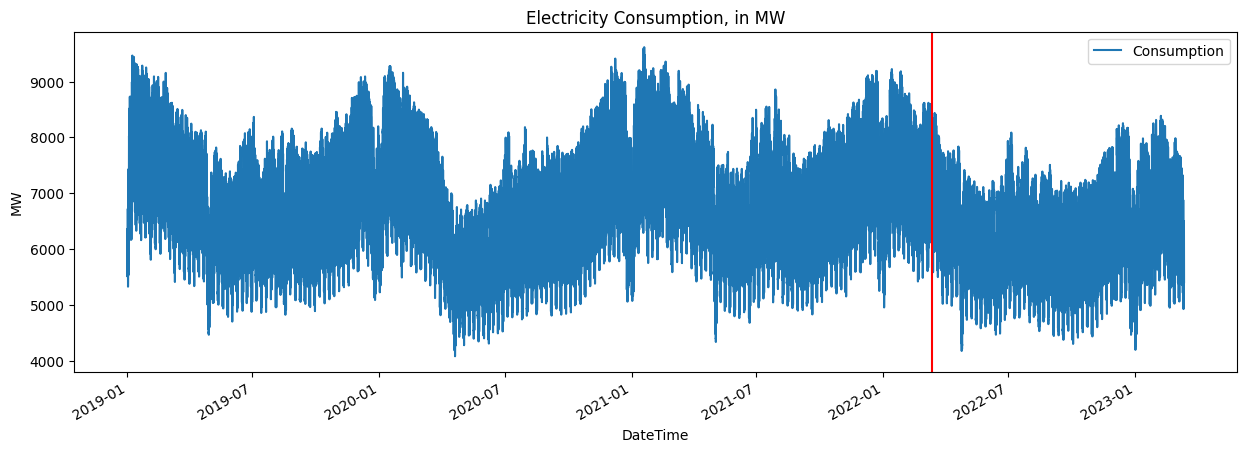

In [9]:
cutOffDate = df.index[-365 * 24]
print(f"cutOffDate {cutOffDate}")

train = df.loc[df.index <= cutOffDate]
test = df.loc[df.index > cutOffDate]

print(f"train size: {len(train)} and test {len(test)}")

df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.axvline(x=cutOffDate, color='r')
plt.show()

In [10]:
def meanAbsolutErrorAaPercentage(real, predicted):
    real = np.array(real)
    predicted = np.array(predicted)

    return np.mean(np.abs((real - predicted) / real)) * 100

In [11]:
%%time

# define our features and our target as separate arrays
FEATURES = ["hour", "day_of_week", "quarter", "month", "year", "day_of_year"]
TARGET = "Consumption"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# define and XGB regressor, fit it on our train data and use it to predict our test data
regressor = xgb.XGBRegressor(n_estimators=1000, early_stoppin_rounds=50, learning_rate=0.01)

regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
regressorOutput = regressor.predict(X_test)

prediction = pd.DataFrame(data=regressorOutput, index=X_test.index, columns=["prediction"])

df = df.merge(prediction, how="left", left_index=True, right_index=True)

# our predictions are at the end of the dataframe, so we should print that
df.tail()

[0]	validation_0-rmse:1032.79699	validation_1-rmse:1045.39781


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:06:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stoppin_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:538.51188	validation_1-rmse:735.28616
[200]	validation_0-rmse:374.82591	validation_1-rmse:705.28202
[300]	validation_0-rmse:311.97531	validation_1-rmse:705.39659
[400]	validation_0-rmse:271.83271	validation_1-rmse:706.39158
[500]	validation_0-rmse:245.75869	validation_1-rmse:704.59735
[600]	validation_0-rmse:228.38289	validation_1-rmse:711.96299
[700]	validation_0-rmse:216.29585	validation_1-rmse:717.11446
[800]	validation_0-rmse:206.56454	validation_1-rmse:719.41389
[900]	validation_0-rmse:197.41312	validation_1-rmse:718.73906
[999]	validation_0-rmse:190.22871	validation_1-rmse:720.89060
CPU times: user 21.2 s, sys: 171 ms, total: 21.4 s
Wall time: 6.05 s


,Consumption,hour,day_of_week,quarter,month,year,day_of_year,prediction
DateTime,,,,,,,,
2023-03-12 19:00:00,6500,19,6,1,3,2023,71,7314.051758
2023-03-12 20:00:00,6471,20,6,1,3,2023,71,7323.088867
2023-03-12 21:00:00,6194,21,6,1,3,2023,71,7045.944336
2023-03-12 22:00:00,5708,22,6,1,3,2023,71,6621.527344
2023-03-12 23:00:00,5409,23,6,1,3,2023,71,6319.262695


In [12]:
# select the part of the data frame that is our test part
testDf = df.loc[df.index > cutOffDate]

yReal = testDf["Consumption"]
yPredicted = testDf["prediction"]

print(f"percentage error: {meanAbsolutErrorAaPercentage(yReal, yPredicted):.4f}")

percentage error: 10.2054


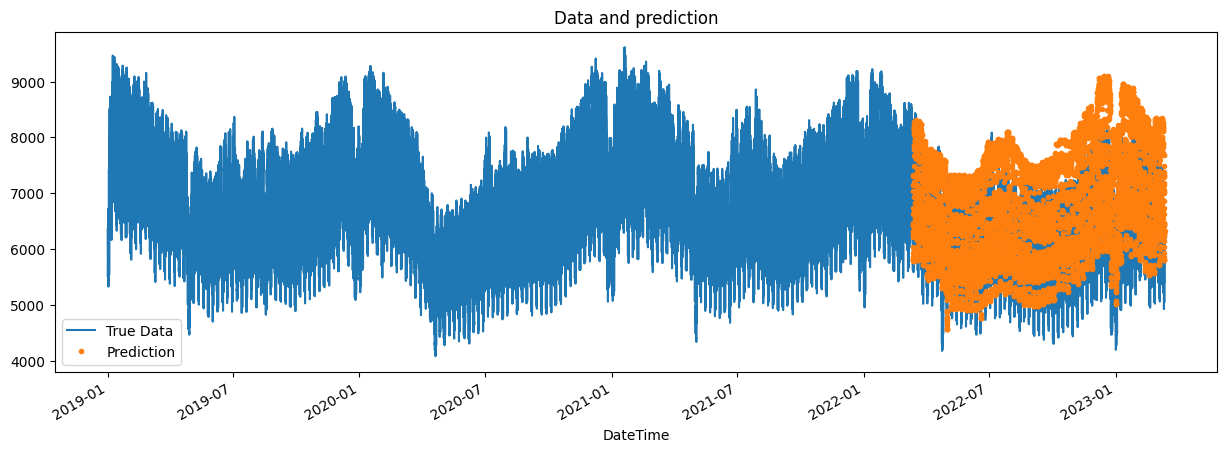

In [13]:
ax = df[[TARGET]].plot(figsize=(15,5))
df["prediction"].plot(ax=ax, style=".")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()


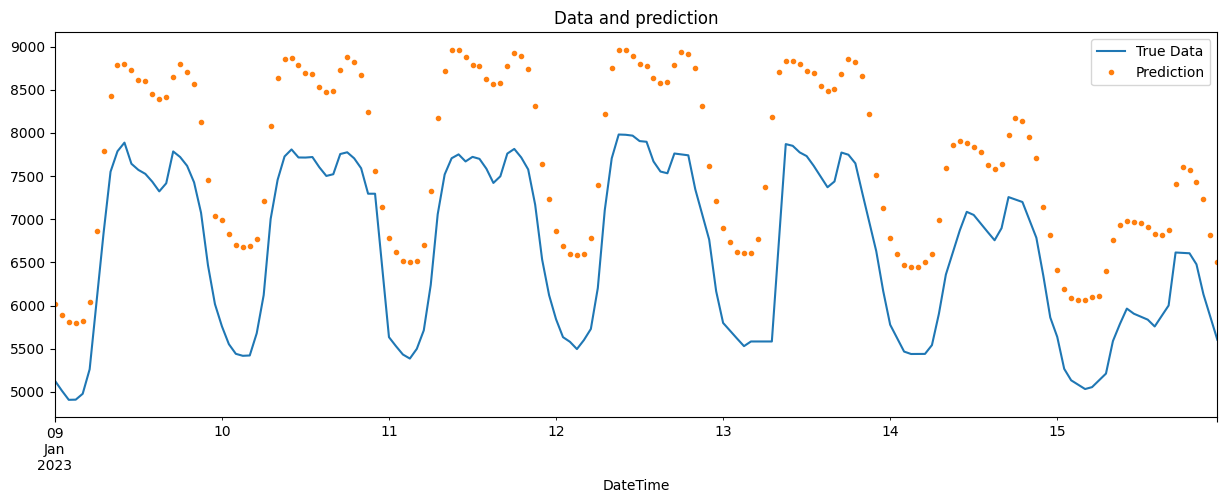

In [14]:
ax = df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][[TARGET]].plot(figsize=(15,5))
df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"]["prediction"].plot(ax=ax, style=".")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

In [15]:
prophetTrain = train.reset_index()
prophetTrain.drop(FEATURES, axis=1, inplace=True)
prophetTrain.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTrain.tail()

,ds,y
28008,2022-03-12 21:00:00,7458
28009,2022-03-12 22:00:00,6912
28010,2022-03-12 23:00:00,6377
28011,2022-03-13 00:00:00,6119
28012,2022-03-13 01:00:00,5864


In [16]:
prophetTest = test.reset_index()
prophetTest.drop(FEATURES, axis=1, inplace=True)
prophetTest.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTest.tail()

,ds,y
8754,2023-03-12 19:00:00,6500
8755,2023-03-12 20:00:00,6471
8756,2023-03-12 21:00:00,6194
8757,2023-03-12 22:00:00,5708
8758,2023-03-12 23:00:00,5409


In [17]:
%%time

prophetModel = Prophet()
prophetModel.fit(prophetTrain)

prophetPrediction = prophetModel.predict(prophetTest)

yRealProphet = test["Consumption"]
yPredictedProphet = prophetPrediction["yhat"]

print(f"prophet percentage error: {meanAbsolutErrorAaPercentage(yRealProphet, yPredictedProphet):.4f}")

15:06:20 - cmdstanpy - INFO - Chain [1] start processing
15:06:57 - cmdstanpy - INFO - Chain [1] done processing


prophet percentage error: 5.5591
CPU times: user 5.84 s, sys: 945 ms, total: 6.78 s
Wall time: 44 s


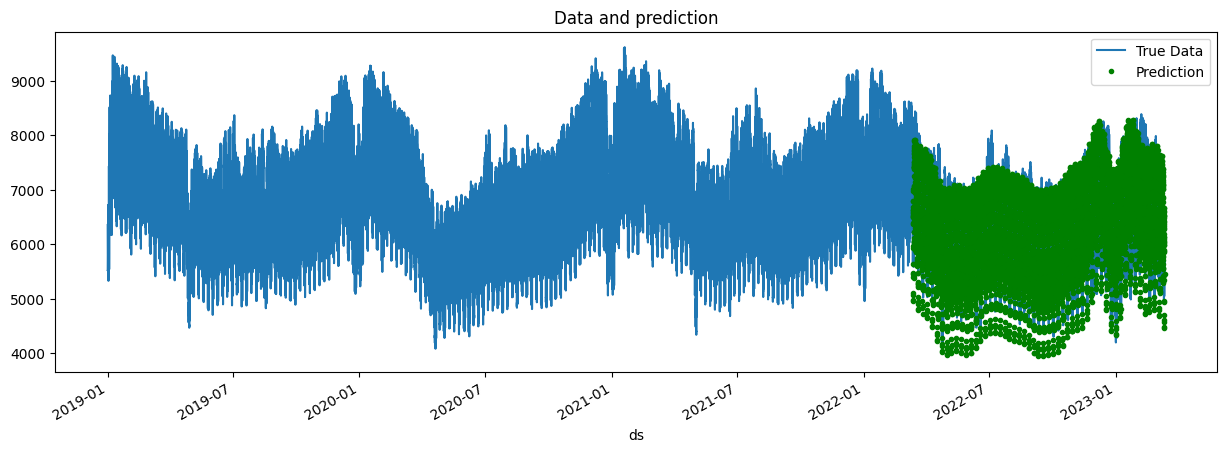

In [18]:
# in order to be optimaly plot the data we set it's ds (our initial DateTime) as the index
prophetPrediction = prophetPrediction.set_index("ds")

ax = df[[TARGET]].plot(figsize=(15,5))
prophetPrediction["yhat"].plot(ax=ax, style=".", color="g")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

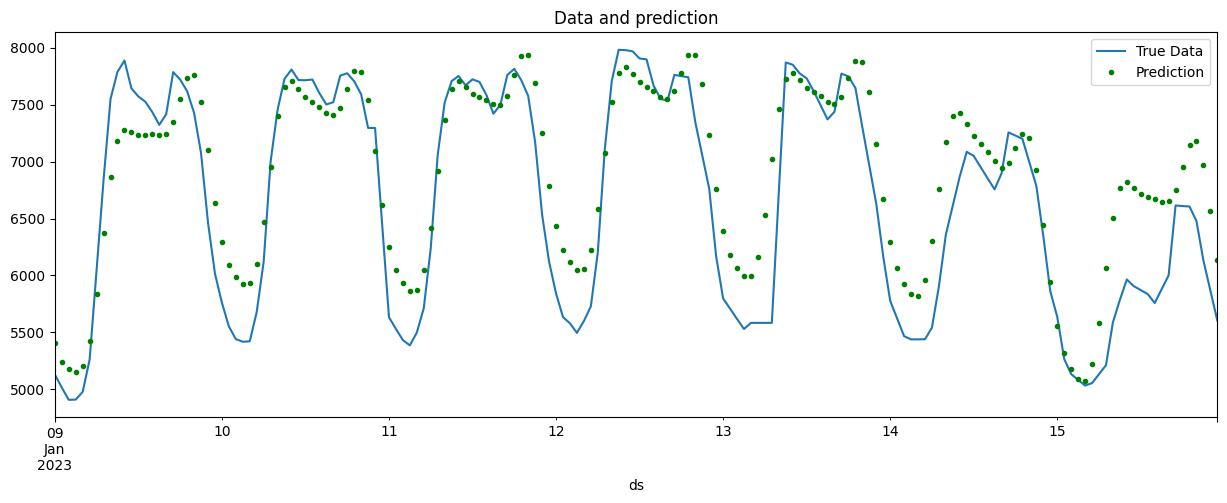

In [19]:
ax = df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][[TARGET]].plot(figsize=(15,5))
prophetPrediction["2023-01-09 00:00:00" : "2023-01-15 23:59:59"]["yhat"].plot(ax=ax, style=".", color="g")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()